In [1]:
import numpy as np
import random
from collections import deque

In [31]:
# Function to read the QAP instance from the file
def read_qap_instance(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Size of the problem (First value of the first line)
    n = int(lines[0].split()[0])  # Number of facilities/locations
    
    flow = []
    distance = []
    reading_flow = True
    
    # Start processing the lines from line 3 onward (index 2)
    for line in lines[2:]:
        stripped_line = line.strip()
        
        # If the line is empty, it means we've reached the distance matrix
        if stripped_line == '':
            reading_flow = False  # Transition to distance matrix
            continue
        
        # Convert the current line to a list of integers
        row = [int(x) for x in stripped_line.split()]
        
        # Check if the row is valid and has 'n' elements
        if len(row) == n:
            if reading_flow:
                flow.append(row)
            else:
                distance.append(row)

    return n, np.array(flow), np.array(distance)

In [32]:
try:
    n, flow, distance = read_qap_instance("tai12a.dat")
    print("\nNumber of facilities / locations:", n)
    print("Flow matrix:\n", flow)
    print("Distance matrix:\n", distance)
except ValueError as e:
    print(f"Error reading QAP instance: {e}")


Number of facilities / locations: 12
Flow matrix:
 [[ 0 27 85  2  1 15 11 35 11 20 21 61]
 [27  0 80 58 21 76 72 44 85 94 90 51]
 [85 80  0  3 48 29 90 66 41 15 83 96]
 [ 2 58  3  0 74 45 65 40 54 83 14 71]
 [ 1 21 48 74  0 77 36 53 37 26 87 76]
 [15 76 29 45 77  0 91 13 29 11 77 32]
 [11 72 90 65 36 91  0 87 67 94 79  2]
 [35 44 66 40 53 13 87  0 10 99 56 70]
 [11 85 41 54 37 29 67 10  0 99 60  4]
 [20 94 15 83 26 11 94 99 99  0 56  2]
 [21 90 83 14 87 77 79 56 60 56  0 60]
 [61 51 96 71 76 32  2 70  4  2 60  0]]
Distance matrix:
 [[ 0 21 95 82 56 41  6 25 10  4 63  6]
 [21  0 44 40 75 79  0 89 35  9  1 85]
 [95 44  0 84 12  0 26 91 11 35 82 26]
 [82 40 84  0 69 56 86 45 91 59 18 76]
 [56 75 12 69  0 39 18 57 36 61 36 21]
 [41 79  0 56 39  0 71 11 29 82 82  6]
 [ 6  0 26 86 18 71  0 71  8 77 74 30]
 [25 89 91 45 57 11 71  0 89 76 76 40]
 [10 35 11 91 36 29  8 89  0 93 56  1]
 [ 4  9 35 59 61 82 77 76 93  0 50  4]
 [63  1 82 18 36 82 74 76 56 50  0 36]
 [ 6 85 26 76 21  6 30 40  1  4 

In [33]:
# Cost function for a given permutation
def calculate_cost(permutation, flow, distance):
    n = len(permutation)
    cost = 0
    for i in range(n):
        for j in range(n):
            cost += flow[i][j] * distance[permutation[i]][permutation[j]]
    return cost

In [34]:
# Generate initial solution (random permutation)
def generate_initial_solution(n):
    return np.random.permutation(n)

In [63]:
# Get the neighbors by swapping two positions
def get_neighbors(solution):
    neighbors = []
    n = len(solution)
    for i in range(n):
        for j in range(i + 1, n):
            neighbor = solution.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append((neighbor, (i, j)))  # (solution, swap_indices)
    return neighbors

In [74]:
def tabu_search(flow, distance, tabu_tenure=5, max_iterations=500):
    n = len(flow)
    
    # ------------------
    # _1_ Initialization
    # ------------------

    # Initialize the solution
    current_solution = generate_initial_solution(n)
    current_cost = calculate_cost(current_solution, flow, distance)
    
    # Best solution tracking
    best_solution = current_solution
    best_cost = current_cost
    
    # Tabu list to store forbidden moves
    tabu_list = deque(maxlen=tabu_tenure)

    # -------------------------------------
    # _3_ Loop until a stop criterion is met
    # -------------------------------------
    for iteration in range(max_iterations):

        # Generate neighbors
        neighbors = get_neighbors(current_solution)
        
        # Best candidate selection
        best_candidate = None
        best_candidate_cost = float('inf')
        best_swap = None

        # Evaluate all neighbors
        for neighbor, swap in neighbors:
            neighbor_cost = calculate_cost(neighbor, flow, distance)

            # Check if the move is tabu
            # A tabu move is allowed ONLY if it produces a solution better than the best so far
            if (swap not in tabu_list) or (neighbor_cost < best_cost):
                # Always select the best available neighbor, whether it's better or worse
                if neighbor_cost < best_candidate_cost:
                    best_candidate = neighbor
                    best_candidate_cost = neighbor_cost
                    best_swap = swap
        
        # Even if the candidate solution is worse, accept it (as long as it's not in tabu)
        if best_candidate_cost < best_cost:
            # If the candidate improves, update the best solution
            best_solution = best_candidate
            best_cost = best_candidate_cost

        # Update the current solution (accept non-improving solutions)
        current_solution = best_candidate
        current_cost = best_candidate_cost

        # Add the swap to the tabu list
        tabu_list.append(best_swap)

        # Debugging info
        print(f"Iteration {iteration+1} | "
                     f"Current Cost: {current_cost} | Best Cost: {best_cost}")

    # ----------------------------------
    # _3_ Return the best solution found
    # ----------------------------------
    return best_solution, best_cost

In [79]:
best_solution, best_cost = tabu_search(flow, distance, tabu_tenure=20, max_iterations=2000)
    
print("\nBest Solution:", best_solution)
print("Best Cost:", best_cost)

Iteration 1 | Current Cost: 285920 | Best Cost: 285920
Iteration 2 | Current Cost: 272104 | Best Cost: 272104
Iteration 3 | Current Cost: 261172 | Best Cost: 261172
Iteration 4 | Current Cost: 251750 | Best Cost: 251750
Iteration 5 | Current Cost: 241836 | Best Cost: 241836
Iteration 6 | Current Cost: 242786 | Best Cost: 241836
Iteration 7 | Current Cost: 237662 | Best Cost: 237662
Iteration 8 | Current Cost: 241104 | Best Cost: 237662
Iteration 9 | Current Cost: 242816 | Best Cost: 237662
Iteration 10 | Current Cost: 241492 | Best Cost: 237662
Iteration 11 | Current Cost: 241966 | Best Cost: 237662
Iteration 12 | Current Cost: 246610 | Best Cost: 237662
Iteration 13 | Current Cost: 245784 | Best Cost: 237662
Iteration 14 | Current Cost: 244492 | Best Cost: 237662
Iteration 15 | Current Cost: 249686 | Best Cost: 237662
Iteration 16 | Current Cost: 251756 | Best Cost: 237662
Iteration 17 | Current Cost: 244042 | Best Cost: 237662
Iteration 18 | Current Cost: 244962 | Best Cost: 237662
I

---

In [83]:
def tabu_search_with_history(flow, distance, tabu_tenure=5, max_iterations=500):
    n = len(flow)
    
    current_solution = generate_initial_solution(n)
    current_cost = calculate_cost(current_solution, flow, distance)
    
    best_solution = current_solution.copy()
    best_cost = current_cost
    
    tabu_list = deque(maxlen=tabu_tenure)

    costs = []
    best_costs = []
    solutions = []
    
    for iteration in range(max_iterations):
        neighbors = get_neighbors(current_solution)
        
        best_candidate = None
        best_candidate_cost = float('inf')
        best_swap = None

        for neighbor, swap in neighbors:
            neighbor_cost = calculate_cost(neighbor, flow, distance)

            if (swap not in tabu_list) or (neighbor_cost < best_cost):
                if neighbor_cost < best_candidate_cost:
                    best_candidate = neighbor
                    best_candidate_cost = neighbor_cost
                    best_swap = swap
        
        if best_candidate_cost < best_cost:
            best_solution = best_candidate.copy()
            best_cost = best_candidate_cost

        current_solution = best_candidate.copy()
        current_cost = best_candidate_cost

        if best_swap is not None:
            tabu_list.append(best_swap)

        costs.append(current_cost)
        best_costs.append(best_cost)
        solutions.append(current_solution.copy())

    return best_solution, best_cost, solutions, costs, best_costs


In [84]:
import matplotlib.pyplot as plt

def visualize_costs(iteration_numbers, costs, best_costs):
    """Visualizes the costs over iterations."""
    plt.figure(figsize=(12, 6))
    plt.plot(iteration_numbers, costs, label='Current Cost', color='blue', marker='o')
    plt.plot(iteration_numbers, best_costs, label='Best Cost', color='orange', marker='x')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost vs. Iterations in Tabu Search')
    plt.legend()
    plt.grid()
    plt.show()


Best Solution: [ 7  0  5  1 10  9  2  4  8  6 11  3]
Best Cost: 224416


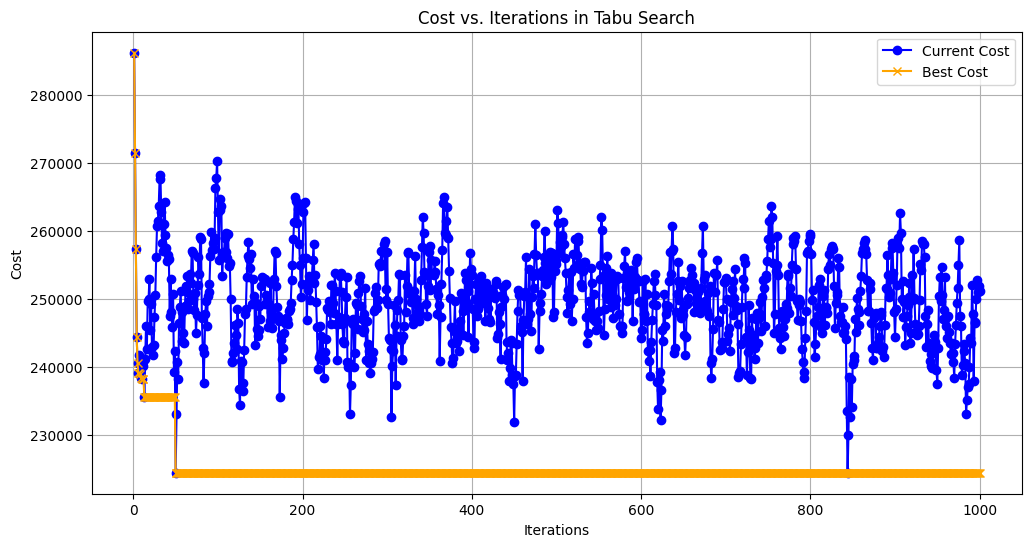

In [85]:
try:
    n, flow, distance = read_qap_instance("tai12a.dat")
    
    # Run Tabu Search
    best_solution, best_cost, solutions, costs, best_costs = tabu_search_with_history(
        flow, distance, tabu_tenure=20, max_iterations=1000
    )
    
    # Print the best solution and cost
    print("\nBest Solution:", best_solution)
    print("Best Cost:", best_cost)
    
    # Visualize costs
    visualize_costs(range(1, len(costs) + 1), costs, best_costs)
    
except ValueError as e:
    print(f"Error: {e}")


---

# Descent Method

In [97]:
def descent_method(flow, distance, max_iterations=500):
    n = len(flow)

    current_solution = generate_initial_solution(n)
    current_cost = calculate_cost(current_solution, flow, distance)

    best_solution = current_solution.copy()
    best_cost = current_cost

    costs = []
    best_costs = []
    solutions = []

    for iteration in range(max_iterations):
        neighbors = get_neighbors(current_solution)

        best_candidate = None
        best_candidate_cost = float('inf')

        for neighbor, _ in neighbors:
            neighbor_cost = calculate_cost(neighbor, flow, distance)

            if neighbor_cost < best_candidate_cost:
                best_candidate = neighbor
                best_candidate_cost = neighbor_cost

        if best_candidate_cost < best_cost:
            best_solution = best_candidate.copy()
            best_cost = best_candidate_cost

            current_solution = best_candidate.copy()
            current_cost = best_candidate_cost
        else:
            print("No improvement found. Stopping.")
            break

        costs.append(current_cost)
        best_costs.append(best_cost)
        solutions.append(current_solution.copy())

    return best_solution, best_cost, solutions, costs, best_costs

No improvement found. Stopping.

Best Solution: [ 7  8  5  1 10  4  2  9  6  0 11  3]
Best Cost: 236768


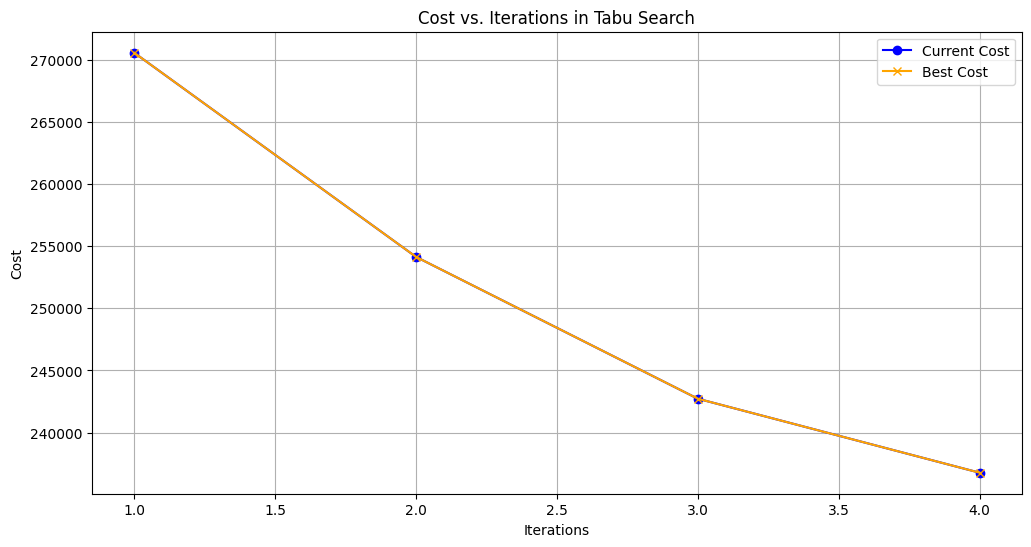

In [99]:
n, flow, distance = read_qap_instance("tai12a.dat")

# Run Descent Method
best_solution, best_cost, solutions, costs, best_costs = descent_method(
    flow, distance, max_iterations=2000
)

# Print the best solution and cost
print("\nBest Solution:", best_solution)
print("Best Cost:", best_cost)

# Visualize costs
visualize_costs(range(1, len(costs) + 1), costs, best_costs)

